## Nemhauser Ullmann Algorithm to solve 0-1 Knapsack problem
This is the implementation for topic `Nemhauser Ullmann Algorithm` from course `Randomized Algorithm and Probability Analysis` at University of Bonn ( Course website: https://nerva.cs.uni-bonn.de/doku.php/teaching/ss23/vl-randalgo )

<img src="images/nemhauser_ullmann_pesudo.png" width="450"/> <img src="images/nemhauser_ullmann_knapsack_theorem.png" width="800"/>

In [29]:
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as patches


class Item:
    def __init__(self, id, weight, profit):
        """
        Represent one item that can be put into the knapsack.
        :param id: Row of item in csv, int
        """
        self.id = id
        self.weight = weight
        self.profit = profit
        self.ratio = profit/weight

    def __repr__(self):
        return f"Item(id={self.id}, weight={self.weight}, profit={self.profit})"


class Point:
    def __init__(self, weight=0., profit=0.):
        """
        Represent a point in the weight/profit diagram. A point is created by a combination of items.
        The IDs of the items used to create this point is saved in item_ids
        :param weight: Sum of the weights of all items in this set
        :param profit: Sum of the profits of all items in this set
        """
        self.weight = weight
        self.profit = profit
        self.item_ids = []

    def __add__(self, item):
        """
        Add an item to this point by adding its weight and profit to the weight and profit
        of the point and also saving its id.
        :param item:
        :return:
        """
        moved_point = Point(self.weight+item.weight, self.profit+item.profit)
        moved_point.item_ids = self.item_ids.copy()
        moved_point.item_ids.append(item.id)
        return moved_point

    def __repr__(self):
        return f"Point(weight={self.weight}, profit={self.profit}, items={self.item_ids})"


def read_file(filename):
    """
    Read file and return list of items
    :param filename: csv input filename
    """

    def parse_row(index, row):
        """
        :param row: row is a list of two strings, first the weight, then the price
        :return: Item instance for the given row
        """
        weight, price = (float(number) for number in row)
        return Item(index, weight, price)

    with open(filename, "r") as f:
        reader = csv.reader(f)
        # skip header, read item rows
        next(reader)
        items = [parse_row(index+1, row) for index, row in enumerate(reader)]
    return items


def find(list_, criterion, default):
    """
    Return the index of the first item that satisfies the criterion in list_. If no item satisfies the criterion,
    the default value is returned
    :param list_: Iterable of items to search in
    :param criterion: Function that takes one element and compares true or false
    :param default: Default value to return if no item matches criterion
    :return: Index of first item for which criterion returns true
    """
    return next((index for index, el in enumerate(list_) if criterion(el)), default)


def find_larger_profit(list_, value, default=None):
    """
    Return the index of the first item in list__ whose profit is larger than value
    """
    return find(list_, lambda x: x.profit > value, default)


def find_max_below(list_, value, default=None):
    """
    Return the index of the item in the list whose weight is closest to, but smaller than value
    """
    return find(list_, lambda x: x.weight > value, default) - 1


def merge(old_list, new_list, weight_limit):
    """
    Takes two lists of pareto-optimal points and merges them, discarding points that are dominated by others.
    Point A is dominated by point B if B achieves a larger profit with the same or less weight than A.
    :param old_list: Previous list of pareto optimal points
    :param new_list: New List of pareto optimal points, where one item was added to every point from the old list
    :param weight_limit: Max weight to reduce number of points
    :return: Merged list excluding points that are dominated by others
    """

    merged_list = []
    profit_max = -1
    
    # Go though each value in descending order
    while True:
        # Item's index of largest profit of P_(i-1) and P_(i-1)^(+i)
        old_point_index = find_larger_profit(old_list, profit_max)
        new_point_index = find_larger_profit(new_list, profit_max)
        
        # Exclude when found point is above the weight limit
        if old_point_index is None or old_list[old_point_index].weight > weight_limit:
            merged_list += new_list[new_point_index:]
            break
        if new_point_index is None or new_list[new_point_index].weight > weight_limit:
            merged_list += old_list[old_point_index:]
            break

        # Get largest point from set P_(i-1) and P_(i-1)^(+i)
        old_p = old_list[old_point_index]
        new_p = new_list[new_point_index]
        
        # Step 3 + 4: Merge list & Check for dominance
        if old_p.weight < new_p.weight or \
                (old_p.weight == new_p.weight and old_p.profit > new_p.profit):
            merged_list.append(old_p)
            profit_max = old_p.profit
        else:
            merged_list.append(new_p)
            profit_max = new_p.profit
        
    return merged_list


def nemhauser_ullmann_knapsack(items, weight_limit):
    """
    Solve 01-knapsack problem for given list of items and weight limit.
    :param items: list of possible items to chose from. No multiples of one item will be taken.
    :param weight_limit: Maximim weight to fill knapsack to
    :return: Ids of items in the list of items, starting at 1 for the first item in the list
    """
    # Initialize pareto-optimal set (step 1: initialize P_0)
    Pi = [Point()]
    # add items to possible pareto optimal sets one by one, but merge by only keeping the optimal points
    for item in items:
        # filter out item combinations that lie above the weight limit
        
        Qi = [point + item for point in Pi]
        # Step 3 + 4: merge P_(i-1) and P_(i-1)^(+i)
        Pi = merge(Pi, Qi, weight_limit)
        Pi = sorted(Pi, key=lambda x: x.weight, reverse=False)
    
    # Compute the pareto set (Step 5: check for dominance)
    pareto_ids_below_limit = Pi[find_max_below(Pi, weight_limit)]
    pareto_set_below_limit = [items[pareto_id-1] for pareto_id in pareto_ids_below_limit.item_ids]

    return pareto_set_below_limit


def visualize_pareto_set(weights, profits, pareto_set, weight_limit):
    """
    Visualize weight-profit graph with pareto set being highlighted
    """

    # Pareto points
    pareto_set = [Point()] + sorted(pareto_set, key=lambda x: x.weight)
    pareto_points = [(item.weight, item.profit) for item in pareto_set]

    # Plot all points
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(weights, profits, color='black', alpha=0.3)

    # Add circle patch to pareto point
    for pareto_point in pareto_points:
        circle = patches.Circle(pareto_point, radius=1, fill=False, edgecolor='black')
        ax.add_patch(circle)

    # Highlight pareto points
    for pareto_item in pareto_set:
        ax.plot(pareto_item.weight, pareto_item.profit, 'bo', markersize=10)

    # Label axes
    ax.set_xlabel('weight')
    ax.set_ylabel('profit')

    # Show grid
    ax.grid(True)
    plt.show()

Nemhauser ullmann for Knapsacks problem running time 
--- 0.0020711421966552734 seconds ---
Pareto set: [Item(id=1, weight=3.0, profit=30.0), Item(id=2, weight=16.0, profit=36.0), Item(id=6, weight=38.0, profit=82.0), Item(id=12, weight=61.0, profit=95.0)]

Weight limit: 120
Total weight: 118.0
Total profit: 243.0


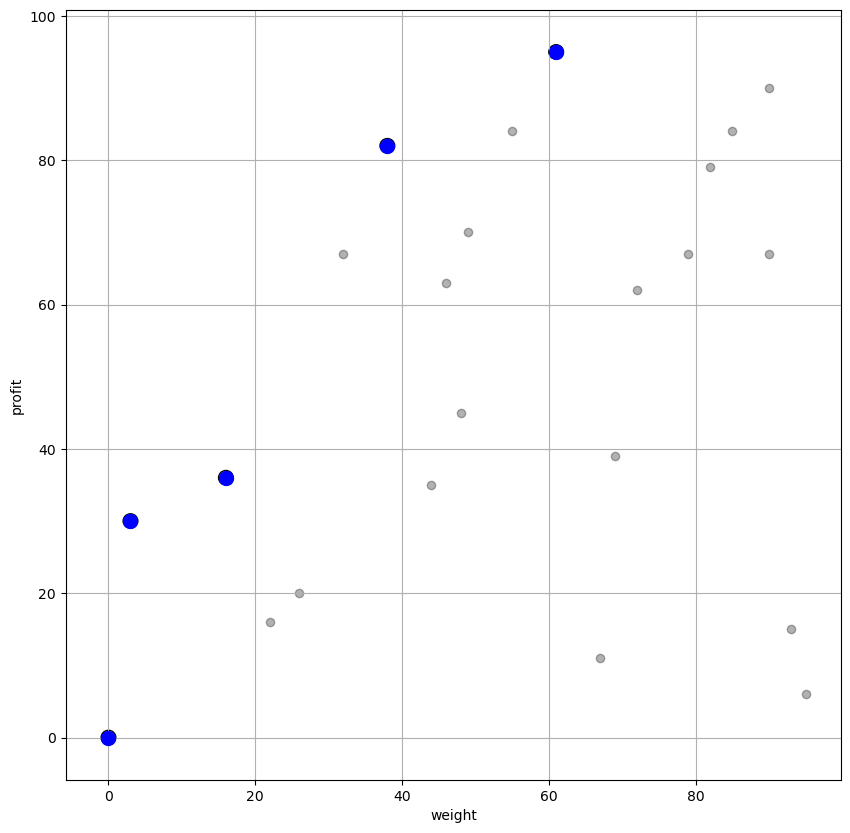

In [34]:
import time

# Params
items = read_file('weight_profit_list.csv')
weight_limit = 120

# Run Nemhauser-Ullmann algorithm to get the Pareto set
# pareto_set, culmulative_w_p = knapsack(items, weight_limit)
start_time = time.time()
pareto_set = nemhauser_ullmann_knapsack(items, weight_limit)
print(f"Nemhauser ullmann for Knapsacks problem running time \n--- {time.time() - start_time} seconds ---")

# Exclude the items in the Pareto set for visualization
pareto_ids = [item.id for item in pareto_set]
weights = [item.weight for item in items if item.id not in pareto_ids]
profits = [item.profit for item in items if item.id not in pareto_ids]

# Visualize the Pareto set
print(f'Pareto set: {pareto_set}\n')
print(f'Weight limit: {weight_limit}')
print(f'Total weight: {sum(item.weight for item in pareto_set)}')
print(f'Total profit: {sum(item.profit for item in pareto_set)}')
visualize_pareto_set(weights, profits, pareto_set, weight_limit)